In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
#import h5py
import sys
import os
import pyflct
from scipy.stats import pearsonr
from tqdm import tqdm
import time
# We need this to navigate through our data
import muram as mio

# Input/output
from astropy.io import fits

# Let's open the first two files from timeseries for tau = 1 to get the actual velocities
# and let's open the first two files from I_out series that contains continuum intensity
# on which pyFLCT will do the tracking

# Initializing list of names of all the files
filenames = []

# Retreiving only numerical files
for file in sorted(os.listdir (os.getcwd())):
	if file.startswith("tau_slice_0.100"):
		#print (file)
		filenames.append(file)

# Here we look at binary files, so we should open them using numpy, but firstly, we will
# create empty lists to which we will append read values

bz = []
vxr = []
vyr = []
icont = []

# Looping through all the slices for general purpose, but limited to 2 for testing purposes
test_range = 4
for iter in range(test_range):
    test = filenames[iter]
    print(test)
    data_full = np.fromfile(test, dtype="float32")
    data = data_full[4:].reshape(11, 1536, 1536)
    Bz = data[7,:,:]
    Vx = data[1,:,:]
    Vy = data[2,:,:]
    vxr.append(Vx)
    vyr.append(Vy)
    bz.append(Bz)

# Since intensity is stored in separate series of files, we use new for loop
# that will go through all of them 
path = ''
start = 0 #iter to start from 
step = 50 # step
number = 361 # total number 

for i in tqdm(range(number)):

	snapshot = start + i*step

	# For the intensity
	test=mio.MuramIntensity(path, snapshot)
	icont.append(test)

bz = np.asarray(bz)
vxr = np.asarray(vxr)
vyr = np.asarray(vyr)
icont = np.asarray(icont)

print("Bz shape:", np.shape(bz))
# Now we can define cadence, FWHM, pixelsize and sigma that FLCT will use 

deltat = 30 # in seconds
fwhm = 100 # in kilometres
pixelsize = 16 # in kilometres
sigma = fwhm/1.665/pixelsize # size of the apodizing window
threshold = 0
# To make it a little easier to compare FLCT velocities with the actual ones
# by using arithmetic mean

vxmean = []
vymean = []
'''
for j in range(1, len(vxr)):
    vx = (vxr[j-1] + vxr[j])/2/1e5
    vxmean.append(vx)
    vy = (vyr[j-1] + vyr[j])/2/1e5
    vymean.append(vy)
vxmean = np.asarray(vxmean)
vymean = np.asarray(vymean)
'''
vxmean = (vxr[0]+vxr[3])/2
vymean = (vyr[0]+vyr[3])/2
vxmean = np.asarray(vxmean)
vymean = np.asarray(vymean)

vxb, vyb, vmb = pyflct.flct(bz[0], bz[3], deltat, pixelsize, sigma, thresh = 0)
vxb = np.asarray(vxb)
vyb = np.asarray(vyb)
vmb = np.asarray(vmb)

# Define empty lists for FLCT velocities
icont = icont[:4]
print(len(icont))
vx = [] 
vy = []
vm = [] # mask that tells the user which pixels were skipped by designing 0 value at such pixels

ts = time.time()
'''
for j in range(0, len(icont)):
    vel_x, vel_y, vm_ = pyflct.flct(icont[0], icont[4], deltat, pixelsize, sigma, thresh = threshold)
    vx.append(vel_x)
    vy.append(vel_y)
    vm.append(vm_)

vx, vy, vm = pyflct.flct(icont[0], icont[3], deltat, pixelsize, sigma, thresh = threshold)
vx = np.asarray(vx)
vy = np.asarray(vy)
vm = np.asarray(vm)
'''
# Create the fits file to store these velocities
# with appropriate header
cube = np.concatenate((vxb[None,:,:], vyb[None,:,:]), axis = 0)
print(np.shape(cube))
out0 = fits.PrimaryHDU(cube[0])

# Header information 
out0.header['UNITS'] = 'km/s' # units that velocities are in 
out0.header['TRACKED'] = 'Bz' # the parameter which was tracked
out0.header['WHEN_RUN'] = ts # timestamp of run
out0.header['AUTHOR'] = 'Teodor'
out0.header['FWHM'] = fwhm # in kilometres
out0.header['PIXELSIZE'] = pixelsize
out0.header['SIGMA'] = sigma # FLCT window in kilometres 
out0.header['DELTAT'] = deltat # time interval between two frames in seconds
out0.header['THRESHOLD'] = threshold # FLCT is not applied to pixels below this
out0.header['SIMSTEP'] = 0.2 # should match the filename
out0.header['SIMTIME'] = 3600 # 1 hour
out0.header['COMMENT'] = ''

out1 = fits.ImageHDU(cube[1])
#out2 = fits.ImageHDU(cube[2])
out = fits.HDUList([out0, out1, out2])



out.writeto("pyFLCT_fwhm" + str(fwhm) + "_dt" + str(deltat) + "_Bz_" + filenames[0], overwrite=True)
'''
 # 2D image with vectors overlain
# Needs gridspec & subplot() from matplotlib, imported here as .plt


# Cropping input arrays to show interesting portion
#--------------------------------------------------


xmin = 75
xmax = 225
ymin = 75
ymax=  225


xmin = 100
xmax = 300
ymin = 125
ymax=  275

Bgtx_disp = Bgtx_obs[ymin:ymax,xmin:xmax]
Bgty_disp = Bgty_obs[ymin:ymax,xmin:xmax]
Bgtz_disp = Bgtz_obs[ymin:ymax,xmin:xmax]

ysize,xsize = np.shape(Bgtx_disp)

stride = 5


xmaxind = int(round(xsize/stride))
ymaxind = int(round(ysize/stride))

xstr, ystr = np.meshgrid(stride*np.arange(0,xmaxind),stride*np.arange(0,ymaxind))


Bgth = np.sqrt(Bgtx_disp**2 + Bgty_disp**2)

#where_big_bgth= np.where(Bgth[y,x] > 125)
where_small_bgth= np.where(Bgth[y,x] < 100)

Bgtx_disp[where_small_bgth] = 0
Bgty_disp[where_small_bgth] = 0


plt.imshow(Bgtz_disp, origin = 'lower')
plt.quiver(xstr,ystr,Bgtx_disp[::stride,::stride],Bgty_disp[::stride,::stride])

plt.savefig('vector.png',dpi = 100)


# Set min. & max. levels for saturation
#--------------------------------------------------
ltmaxsat = 1000
ltminsat = -ltmaxsat
gtmaxsat = 500
gtminsat = -gtmaxsat
deltaminsat = -250
deltamaxsat = 250
gtdeltafactor = 0.25   


fig = plt.figure(figsize = (11,8.5))
gs = gridspec.GridSpec(2,4, height_ratios=[1,1], wspace=.15, hspace=.05)

# Top Row
axarr = plt.subplot(gs[0,0])
axarr.imshow(Btx_obs, origin = 'lower', vmin = gtminsat, vmax = gtmaxsat)
axarr.contour(smBgtz_display, 0, origin = 'lower', cmap ='Reds', linewidths = 1)
plt.title('Btx Observed')

axarr = plt.subplot(gs[0,1])
axarr.tick_params(axis='y', which = 'both', left = True, right = False, labelleft = False, direction = 'in')
axarr.imshow(smBtx_obs, origin = 'lower', vmin = gtminsat, vmax = gtmaxsat)
axarr.contour(smBgtz_display, 0, origin = 'lower', cmap ='Reds', linewidths = 1)
plt.title('Smooth Btx Observed')

axarr = plt.subplot(gs[0,2])
axarr.tick_params(axis='y', which = 'both', left = True, right = False, labelleft = False, direction = 'in')
axarr.imshow(Btx_model, origin = 'lower', vmin = gtminsat, vmax = gtmaxsat)
axarr.contour(smBgtz_display, 0, origin = 'lower', cmap ='Reds', linewidths = 1)
plt.title('Btx Model')

axarr = plt.subplot(gs[0,3])
axarr.tick_params(axis='y', which = 'both', left = True, right = False, labelleft = False, direction = 'in')
axarr.imshow(deltaBtx, origin = 'lower', vmin = deltaminsat * gtdeltafactor, vmax = deltamaxsat * gtdeltafactor)
axarr.contour(smBgtz_display, 0, origin = 'lower', cmap ='Reds', linewidths = 1)
plt.title('Btx Model - Observed')

# Bottom Row
axarr = plt.subplot(gs[1,0])
axarr.imshow(Bty_obs, origin = 'lower', vmin = gtminsat, vmax = gtmaxsat)
axarr.contour(smBgtz_display, 0, origin = 'lower', cmap ='Reds', linewidths = 1)
plt.title('Bgty Observed')

axarr = plt.subplot(gs[1,1])
axarr.tick_params(axis='y', which = 'both', left = True, right = False, labelleft = False, direction = 'in')
axarr.imshow(smBty_obs, origin = 'lower', vmin = gtminsat, vmax = gtmaxsat)
axarr.contour(smBgtz_display, 0, origin = 'lower', cmap ='Reds', linewidths = 1)
plt.title('Smooth Bgty Observed')

axarr = plt.subplot(gs[1,2])
axarr.tick_params(axis='y', which = 'both', left = True, right = False, labelleft = False, direction = 'in')
axarr.imshow(Bty_model, origin = 'lower', vmin = gtminsat, vmax = gtmaxsat)
axarr.contour(smBgtz_display, 0, origin = 'lower', cmap ='Reds', linewidths = 1)
plt.title('Bgty Model')

axarr = plt.subplot(gs[1,3])
axarr.tick_params(axis='y', which = 'both', left = True, right = False, labelleft = False, direction = 'in')
axarr.imshow(deltaBty, origin = 'lower', vmin = deltaminsat * gtdeltafactor, vmax = deltamaxsat * gtdeltafactor)
axarr.contour(smBgtz_display, 0, origin = 'lower', cmap ='Reds', linewidths = 1)
plt.title('Bgty Model - Observed')
'''

i_start = 0
j_start = 0
i_end = 128
j_end = 128
# But first we need to create a meshgrid on which the flow field will be plotted 
X = np.arange(0, 32, 1)
Y = np.arange(0, 32, 1)
U, V = np.meshgrid(X, Y)


# Plotting the first image
fig = plt.figure(figsize=(12, 6))
fig.suptitle(r'$\Delta t=30\mathrm{s}, \quad \mathrm{FWHM}=100 \mathrm{km} $' + " degraded data")
ax1 = fig.add_subplot(121)
ax1.set_xlabel("pixel/4")
ax1.set_ylabel("pixel/4")
ax1.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
           vxmean[i_start:i_end:4, j_start:j_end:4], vymean[i_start:i_end:4, j_start:j_end:4])
ax1.set_title("Flow Field based on mean velocity from simulation, tau=1") 

ax2 = fig.add_subplot(122)
ax2.set_xlabel("pixel/4")
ax2.set_ylabel("pixel/4")
ax2.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
          vxb[i_start:i_end:4, j_start:j_end:4], vyb[i_start:i_end:4, j_start:j_end:4])
ax2.set_title("Flow Field - FLCT; Bz windowing parameter") 

tau_slice_0.100.000000
tau_slice_0.100.000050
tau_slice_0.100.000100
tau_slice_0.100.000150


100%|█████████████████████████████████████████| 361/361 [00:06<00:00, 56.19it/s]


Bz shape: (4, 1536, 1536)
4
flct: nominal sliding box size = 12
flct: mean value of gamma^2/sigma^2 = 0.326077

flct: finished
(2, 1536, 1536)


NameError: name 'out2' is not defined

Text(0.5, 1.0, 'vx derived from pyFLCT')

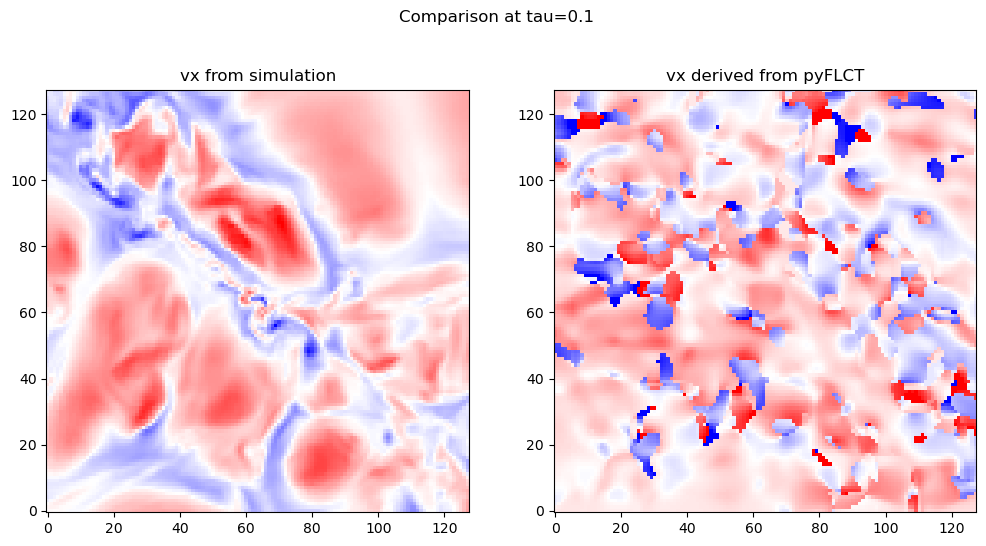

In [17]:
# Let's plot vx from MURaM simulation and vx from pyFLCT
i_start = 0
j_start = 0
i_end = 128
j_end = 128
# But first we need to create a meshgrid on which the flow field will be plotted 
X = np.arange(0, 32, 1)
Y = np.arange(0, 32, 1)
U, V = np.meshgrid(X, Y)


# Plotting the first image
fig = plt.figure(figsize=(12, 6))
fig.suptitle("Comparison at tau=0.1")
ax1 = fig.add_subplot(121)
ax1.imshow(vxr[3, i_start:i_end, j_start:j_end].T, origin='lower',cmap='bwr')
ax1.set_title("vx from simulation") 

ax2 = fig.add_subplot(122)
ax2.imshow(vx[i_start:i_end, j_start:j_end].T, origin='lower', cmap='bwr')
ax2.set_title("vx derived from pyFLCT") 

In [4]:
vxr.shape

(4, 1536, 1536)

In [18]:
vxmean.shape

(1536, 1536)

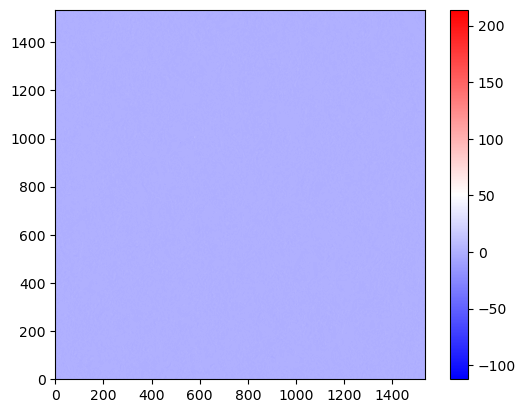

In [2]:
novo_v = fits.open("pyFLCT_fwhm100_dt30_Bz_tau_slice_0.100.000000")[0].data
plt.imshow(novo_v, origin = "lower", cmap = "bwr")
plt.colorbar()

In [2]:
novo_v.shape

NameError: name 'novo_v' is not defined

In [35]:
nn = fits.open("ivan_flct_Bz_30s_tau0.1_fwhm100.fits")[0].data
print(nn.shape)

(1, 1536, 1536)


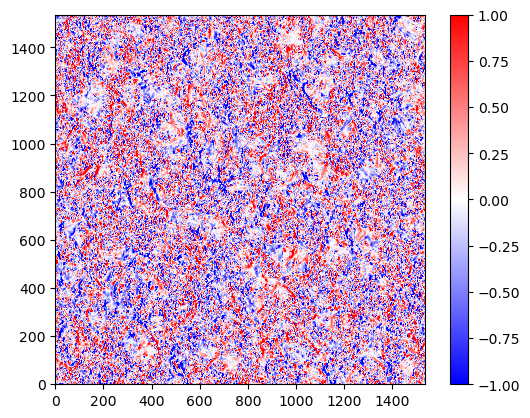

In [33]:
plt.imshow(nn[0,:,:], origin = "lower", cmap = "bwr", vmin = -1, vmax = 1)
plt.colorbar()

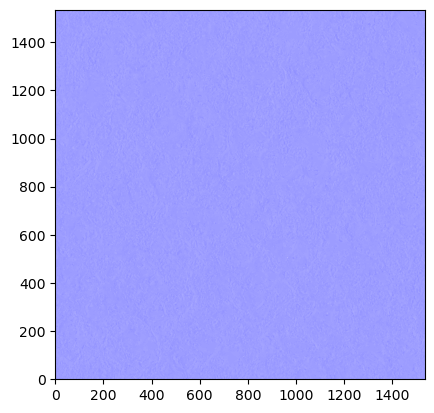

In [13]:
plt.imshow(nn[0,:,:], origin = "lower", cmap = "bwr")

In [16]:
nn.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 1536                                                  
NAXIS2  =                 1536                                                  
NAXIS3  =                    1                                                  
EXTEND  =                    T                                                  

In [5]:
novo_v = fits.open("pyFLCT_fwhm100_dt30_Bz_tau_slice_0.100.000000")[0]
novo_v.header

FileNotFoundError: [Errno 2] No such file or directory: 'pyFLCT_fwhm100_dt30_Bz_tau_slice_0.100.000000'

In [3]:
cube.shape


(3, 1536, 1536)

In [4]:
cube[0]

array([[ 0.09744873,  0.09801136,  0.04120632, ...,  0.97294376,
         0.95741026,  0.93944336],
       [ 0.1732957 ,  0.15840265,  0.06728124, ...,  0.96977647,
         0.94256589,  0.90972361],
       [ 0.37474745,  0.3268362 ,  0.14685846, ...,  0.95542538,
         0.72268737,  0.6669794 ],
       ...,
       [ 0.05085523,  0.05749744,  0.02815509, ...,  0.71436352,
         0.54663343,  0.34273842],
       [ 0.04991208,  0.05863288,  0.03492671, ...,  0.80321989,
         0.72881149,  0.60031997],
       [ 0.05228353,  0.06461823,  0.04861545, ...,  0.84382735,
         0.80381452, -1.15553976]])

In [5]:
cube[2]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [7]:
cube[1]

array([[-0.05942263, -0.04826771, -0.04206767, ..., -0.09861715,
        -0.10508649, -0.11408821],
       [-0.10867243, -0.08438311, -0.07161133, ..., -0.13768515,
        -0.15074628, -0.16939054],
       [-0.09552074, -0.07698435, -0.1345713 , ..., -0.1991618 ,
        -0.4997971 , -0.56154173],
       ...,
       [-0.09637281, -0.07976013, -0.05763339, ..., -0.1802117 ,
        -0.26928413, -0.40262136],
       [-0.06875757, -0.06055761, -0.04950255, ..., -0.08275421,
        -0.17471878, -0.22656851],
       [-0.04612352, -0.04231882, -0.03701971, ..., -0.06034401,
        -0.07244197,  0.19565824]])

In [8]:
cube[0]

array([[ 0.09744873,  0.09801136,  0.04120632, ...,  0.97294376,
         0.95741026,  0.93944336],
       [ 0.1732957 ,  0.15840265,  0.06728124, ...,  0.96977647,
         0.94256589,  0.90972361],
       [ 0.37474745,  0.3268362 ,  0.14685846, ...,  0.95542538,
         0.72268737,  0.6669794 ],
       ...,
       [ 0.05085523,  0.05749744,  0.02815509, ...,  0.71436352,
         0.54663343,  0.34273842],
       [ 0.04991208,  0.05863288,  0.03492671, ...,  0.80321989,
         0.72881149,  0.60031997],
       [ 0.05228353,  0.06461823,  0.04861545, ...,  0.84382735,
         0.80381452, -1.15553976]])

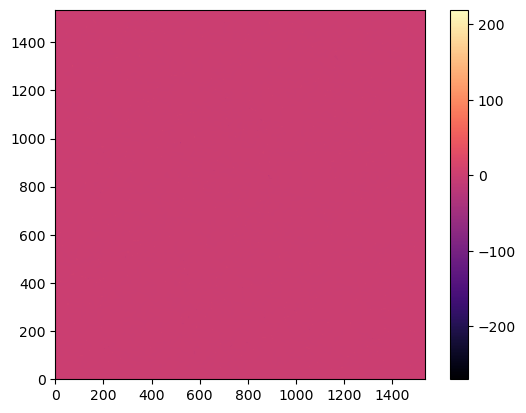

In [11]:
plt.imshow(cube[1], origin = 'lower', cmap = 'magma')
plt.colorbar()


In [12]:
novo = fits.open("pyFLCT_fwhm100_dt30_Bz_tau_slice_0.100.000000.fits")[0]

In [13]:
novo.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 1536                                                  
NAXIS2  =                 1536                                                  
NAXIS3  =                    1                                                  
EXTEND  =                    T                                                  
UNITS   = 'km/s    '                                                            
TRACKED = 'Intensity'                                                           
WHEN_RUN=   1715956622.7976394                                                  
AUTHOR  = 'Teodor  '                                                            
FWHM    =                  100                                                  
HIERARCH PIXELSIZE = 16     

In [14]:
npvp = fits.open("pyFLCT_fwhm100_dt30_Bz_tau_slice_0.100.000150.fits")[0].data

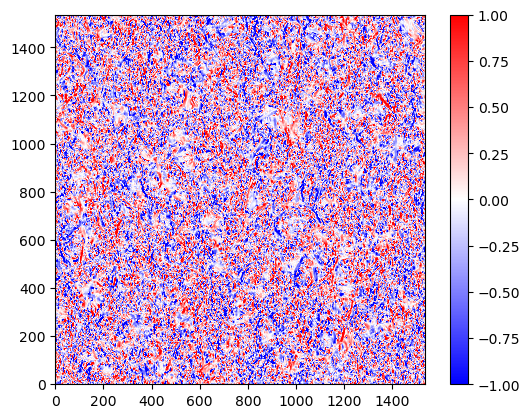

In [37]:
plt.imshow(npvp[:,:], origin = "lower", cmap = "bwr", vmin = -1, vmax = 1)
plt.colorbar()

In [36]:
print(npvp)
print(npvp.shape)

[[ 0.09744873  0.09801136  0.04120632 ...  0.97294376  0.95741026
   0.93944336]
 [ 0.1732957   0.15840265  0.06728124 ...  0.96977647  0.94256589
   0.90972361]
 [ 0.37474745  0.3268362   0.14685846 ...  0.95542538  0.72268737
   0.6669794 ]
 ...
 [ 0.05085523  0.05749744  0.02815509 ...  0.71436352  0.54663343
   0.34273842]
 [ 0.04991208  0.05863288  0.03492671 ...  0.80321989  0.72881149
   0.60031997]
 [ 0.05228353  0.06461823  0.04861545 ...  0.84382735  0.80381452
  -1.15553976]]
(1536, 1536)


<p>
    22. 05. 2024.
    <br>
    Comparison of Ivan's data using mpi code and basic code that just takes correspondent frames
</p>

Text(0.5, 1.0, 'My code')

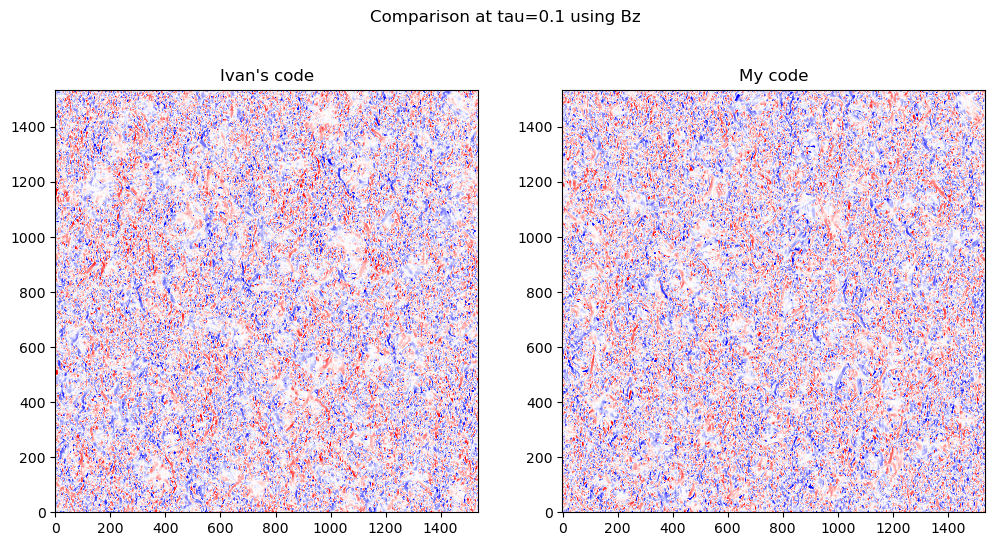

In [7]:
cube_Ivan = fits.open("ivan_flct_Bz_30s_tau0.1_fwhm100_tracked.fits")[0].data
cube_Teodor = fits.open("pyFLCT_fwhm100_dt30_Bz_tau_slice_0.100.000150.fits")[0].data 
fig = plt.figure(figsize = (12,6))
fig.suptitle("Comparison at tau=0.1 using Bz")
ax1 = fig.add_subplot(121)
ax1.imshow(cube_Ivan[0,:,:], origin='lower',cmap='bwr', vmin = -2, vmax = 2)
ax1.set_title("Ivan's code") 

ax2 = fig.add_subplot(122)
ax2.imshow(cube_Teodor[:,:], origin='lower', cmap='bwr', vmin = -2, vmax = 2)
ax2.set_title("My code") 

<p>
    After previous check, it is obvious that the same feature weren't tracked. For the time being, our focus will avert to
    the computational time.
</p>

In [8]:
I_cube = fits.open("pyFLCT_fwhm100_dt30_I_tracked.fits")[0].data

Text(0.5, 1.0, 'Intensity FLCT, FWHM = 100, cadence = 30')

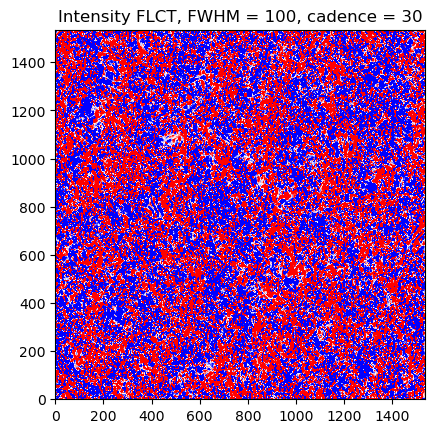

In [19]:
plt.imshow(I_cube[0,:,:], origin='lower', cmap='bwr', vmin = -0.1, vmax = 0.1)
plt.title("Intensity FLCT, FWHM = 100, cadence = 30")

Text(0.5, 1.0, 'Intensity FLCT, FWHM = 1200, cadence = 30')

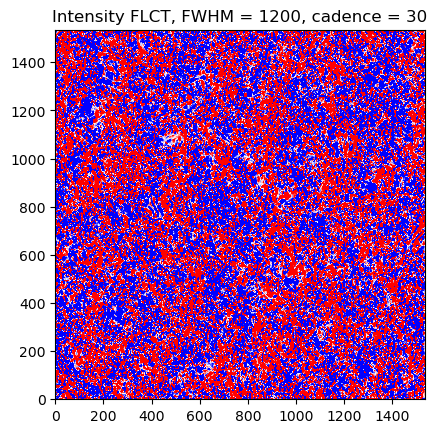

In [18]:
I_cube1200 = fits.open("pyFLCT_fwhm1200_dt30_I_tracked.fits")[0].data
plt.imshow(I_cube[0,:,:], origin='lower', cmap='bwr', vmin = -0.1, vmax = 0.1)
plt.title("Intensity FLCT, FWHM = 1200, cadence = 30")

<p>
    27.05.2024 <br>
    Using FWHM of 1200km, cadence of 30s, but using total of 16 images/frames.
</p>

Text(0.5, 1.0, 'Intensity FLCT, FWHM = 1200, cadence = 30')

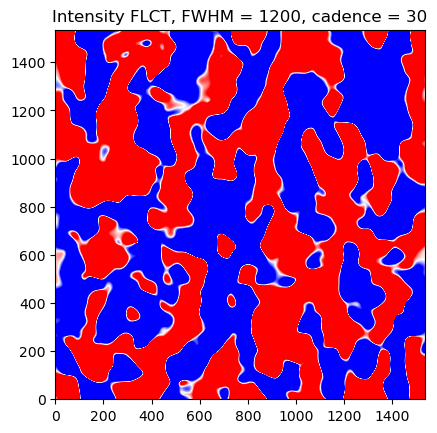

In [15]:
I_cube16I = fits.open("pyFLCT_fwhm1200_dt30_I16_tracked.fits")[0].data
plt.imshow(I_cube16I[0,:,:], origin='lower', cmap='bwr', vmin = -0.1, vmax = 0.1)
plt.title("Intensity FLCT, FWHM = 1200, cadence = 30")

In [10]:
I_cube16I.shape

(15, 1536, 1536)

Text(0.5, 1.0, 'Between 8th and 9th')

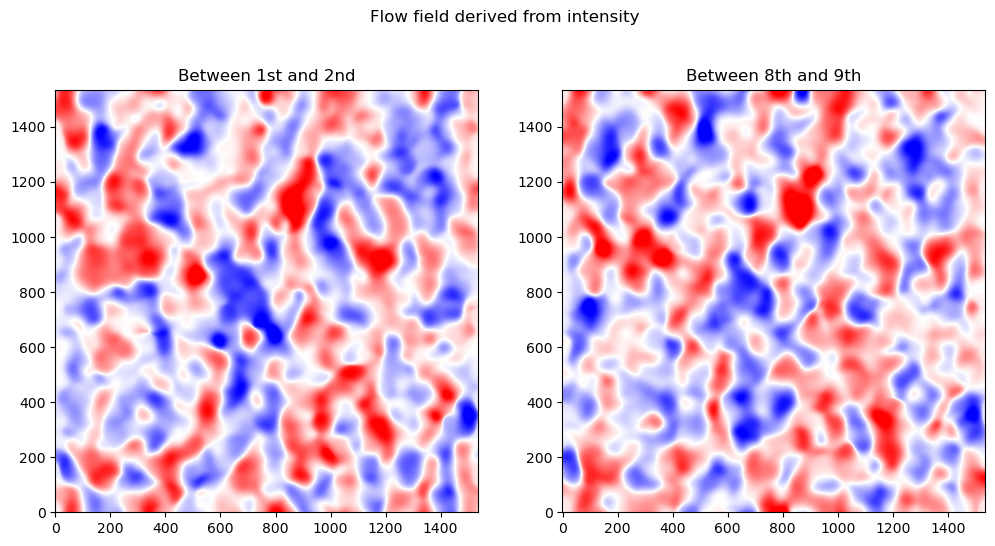

In [13]:
fig = plt.figure(figsize = (12,6))
fig.suptitle("Flow field derived from intensity")
ax1 = fig.add_subplot(121)
ax1.imshow(I_cube16I[0,:,:], origin='lower',cmap='bwr', vmin = -2, vmax = 2)
ax1.set_title("Between 1st and 2nd") 

ax2 = fig.add_subplot(122)
ax2.imshow(I_cube16I[7,:,:], origin='lower', cmap='bwr', vmin = -2, vmax = 2)
ax2.set_title("Between 8th and 9th") 

<p>
    They differ and moving of elements can be seen. Next thing is to compare this wit
</p>